In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings("ignore")

### Prediction
In this notebook i used a bunch of methods to predict. Put RMSE scores for each method in a table and at the end compare them to see wich one will be better

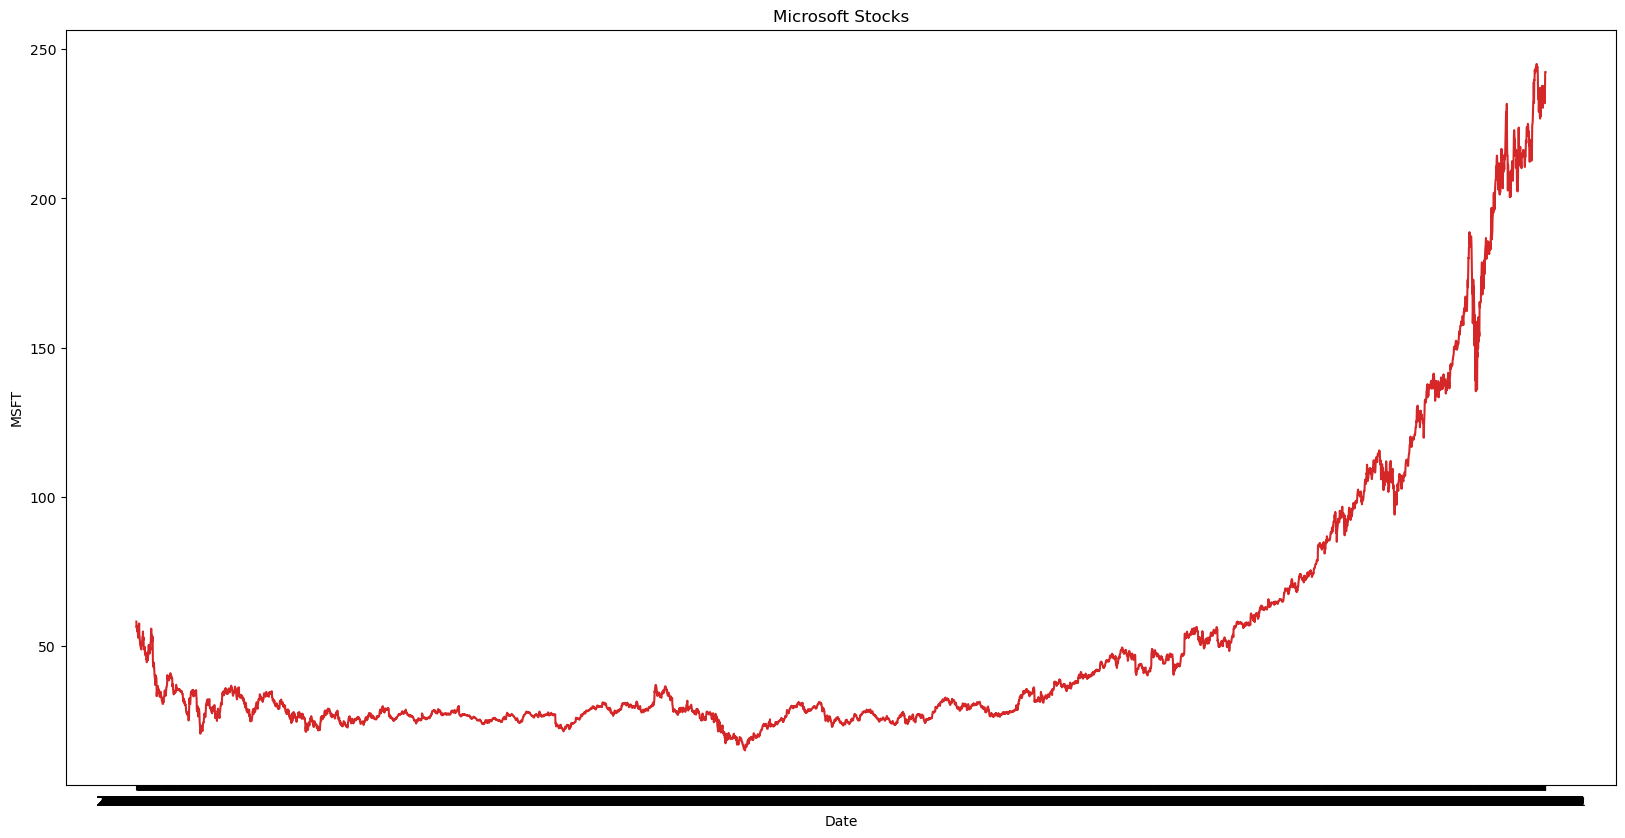

In [2]:
data = pd.read_csv('Data_Microsoft.csv',index_col='Unnamed: 0',parse_dates=['Unnamed: 0'])

def plot_df(data, x, y, title="", xlabel='Date', ylabel='MSFT', dpi=100):
    plt.figure(figsize=(20,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(data, x=data.index, y=data.MSFT,\
        title='Microsoft Stocks')

In [3]:
data.head()

,MSFT
2000-01-03,58.28125
2000-01-04,56.31250
2000-01-05,56.90625
2000-01-06,55.00000
2000-01-07,55.71875


New columns with year and months

In [4]:
data['year'] = pd.DatetimeIndex(data.index).year
data['month'] = pd.DatetimeIndex(data.index).month
years = data['year'].unique()
import calendar
data['month'] = data['month'].apply(lambda x: calendar.month_abbr[x])
data.index = pd.to_datetime(data.index)
data.head()

,MSFT,year,month
2000-01-03,58.28125,2000,Jan
2000-01-04,56.31250,2000,Jan
2000-01-05,56.90625,2000,Jan
2000-01-06,55.00000,2000,Jan
2000-01-07,55.71875,2000,Jan


In [5]:
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype=int64)

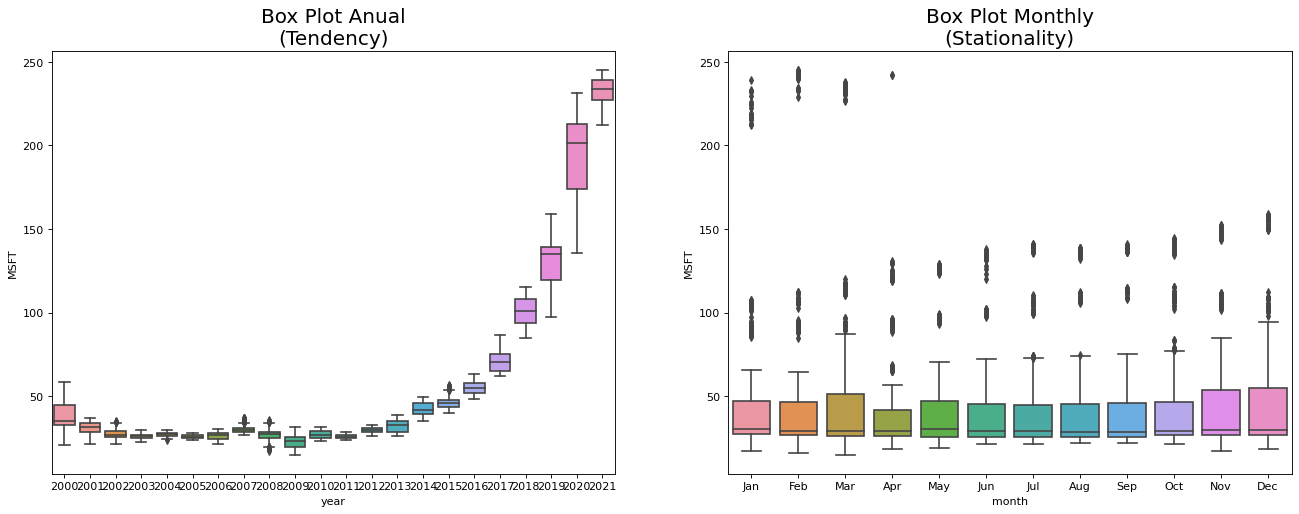

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='MSFT', data=data, ax=axes[0])
sns.boxplot(x='month', y='MSFT', data=data.loc[~data.year.isin([2000, 2020]), :])
axes[0].set_title('Box Plot Anual\n(Tendency)', fontsize=18); 
axes[1].set_title('Box Plot Monthly\n(Stationality)', fontsize=18);

In the first graph we can see value for stocks increase in the last years. Second graph we can see stocks value dont change in each month. Maybe november and december it increase a little bit but nothing too important.

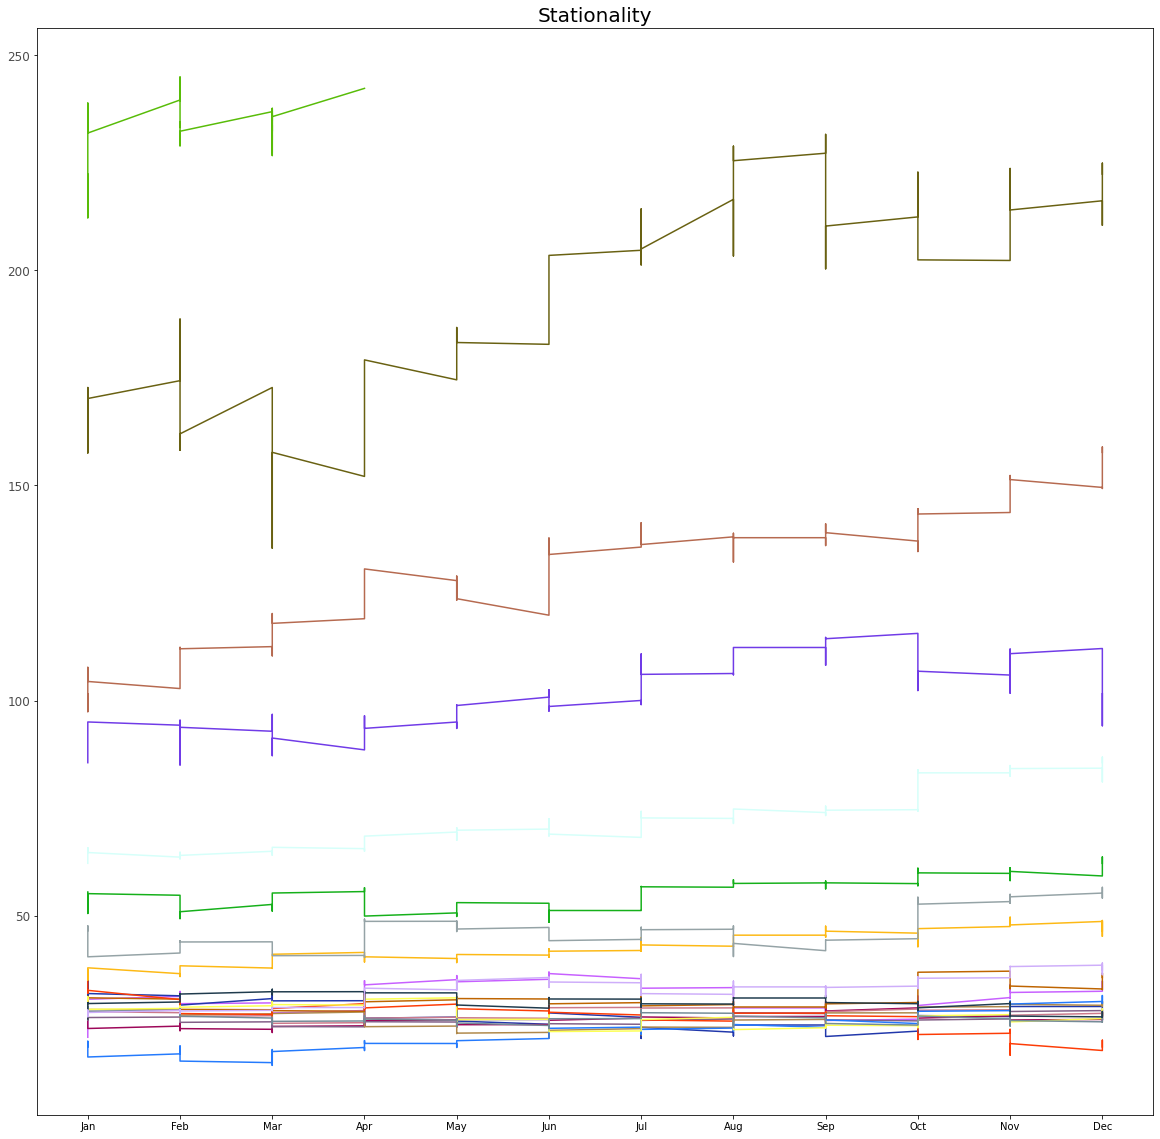

In [7]:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)


plt.figure(figsize=(20,20))
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'MSFT', data=data.loc[data.year==y, :], color=mycolors[i], label=y)     

plt.yticks(fontsize=12, alpha=.7)
plt.title("Stationality", fontsize=20);

Next i'll create the time dummies. I'll use a linear dummy, a cuadratic dummy and an exponential dummy for the trend

In [8]:
#Dummy Time. (Linear,Cuadratic and exp)

data["timeIndex"] = pd.Series(np.arange(len(data['MSFT'])), index=data.index)
data["timeIndex_cuadratic"] = (pd.Series(np.arange(len(data['MSFT'])), index=data.index))**2
data['timeIndex_log'] = np.log(data['MSFT'])

In [9]:
data.head(10)

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log
2000-01-03,58.28125,2000,Jan,0,0,4.065280
2000-01-04,56.31250,2000,Jan,1,1,4.030917
2000-01-05,56.90625,2000,Jan,2,4,4.041405
2000-01-06,55.00000,2000,Jan,3,9,4.007333
2000-01-07,55.71875,2000,Jan,4,16,4.020317
2000-01-10,56.12500,2000,Jan,5,25,4.027581
2000-01-11,54.68750,2000,Jan,6,36,4.001635
2000-01-12,52.90625,2000,Jan,7,49,3.968521
2000-01-13,53.90625,2000,Jan,8,64,3.987246
2000-01-14,56.12500,2000,Jan,9,81,4.027581


Create dummy month and merge with data

In [10]:
# Dummy Month
dummies_month = pd.get_dummies(data['month'], drop_first=True)
dummies_month.head()

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2000-01-03,0,0,0,1,0,0,0,0,0,0,0
2000-01-04,0,0,0,1,0,0,0,0,0,0,0
2000-01-05,0,0,0,1,0,0,0,0,0,0,0
2000-01-06,0,0,0,1,0,0,0,0,0,0,0
2000-01-07,0,0,0,1,0,0,0,0,0,0,0


In [11]:
data = data.join(dummies_month)
data.sample(5)

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2011-04-01,25.480000,2011,Apr,2934,8608356,3.237894,0,0,0,0,0,0,0,0,0,0,0
2009-01-30,17.100000,2009,Jan,2369,5612161,2.839078,0,0,0,1,0,0,0,0,0,0,0
2015-10-23,52.869999,2015,Oct,4124,17007376,3.967836,0,0,0,0,0,0,0,0,0,1,0
2018-06-26,99.080002,2018,Jun,4821,23242041,4.595928,0,0,0,0,0,1,0,0,0,0,0
2016-02-18,52.189999,2016,Feb,4208,17707264,3.954891,0,0,1,0,0,0,0,0,0,0,0


#### Train-Test split. 
Shuffle = False to keep order

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size=600, shuffle=False)

In [13]:
df_train.tail()

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2018-12-10,107.589996,2018,Dec,4940,24403600,4.678328,0,1,0,0,0,0,0,0,0,0,0
2018-12-11,108.589996,2018,Dec,4941,24413481,4.687579,0,1,0,0,0,0,0,0,0,0,0
2018-12-12,109.080002,2018,Dec,4942,24423364,4.692082,0,1,0,0,0,0,0,0,0,0,0
2018-12-13,109.449997,2018,Dec,4943,24433249,4.695468,0,1,0,0,0,0,0,0,0,0,0
2018-12-14,106.029999,2018,Dec,4944,24443136,4.663722,0,1,0,0,0,0,0,0,0,0,0


In [14]:
df_test.head()

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
2018-12-17,102.889999,2018,Dec,4945,24453025,4.633660,0,1,0,0,0,0,0,0,0,0,0
2018-12-18,103.970001,2018,Dec,4946,24462916,4.644102,0,1,0,0,0,0,0,0,0,0,0
2018-12-19,103.690002,2018,Dec,4947,24472809,4.641406,0,1,0,0,0,0,0,0,0,0,0
2018-12-20,101.510002,2018,Dec,4948,24482704,4.620157,0,1,0,0,0,0,0,0,0,0,0
2018-12-21,98.230003,2018,Dec,4949,24492601,4.587312,0,1,0,0,0,0,0,0,0,0,0


In [17]:
df_train.shape

(4945, 17)

In [18]:
df_test.shape

(600, 17)

In [19]:
def RMSE(predicted, actual):
    "Calculates RMSE"
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

#### Baseline with the mean

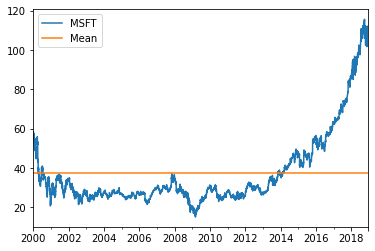

In [20]:
#baseline. Constant Mean
model_mean_pred = df_train['MSFT'].mean()
df_train["Mean"] = model_mean_pred
df_test["Mean"] = model_mean_pred

df_train.plot(kind="line", y = ["MSFT", "Mean"]);

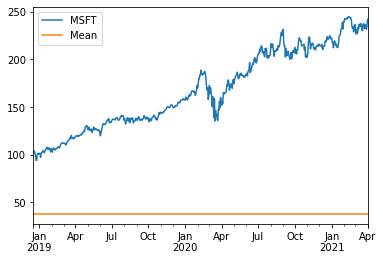

In [21]:
df_test.plot(kind="line", y = ["MSFT", "Mean"]);

In [22]:
#Put RMSE score in Results dataframe
model_mean_RMSE = RMSE(df_test.Mean, df_test.MSFT)
Results = pd.DataFrame(columns = ["Model", "RMSE"])
Results.loc[0, "Model"] = "Mean"
Results.loc[0, "RMSE"] = model_mean_RMSE

#### Random Walk

In [23]:
#random walk

df_train["valueShift1"] = df_train.MSFT.shift()
df_train["valueShift1"].fillna(method='bfill', inplace=True) #first one is NaN. replace with next 
df_train.head()

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,valueShift1
2000-01-03,58.28125,2000,Jan,0,0,4.065280,0,0,0,1,0,0,0,0,0,0,0,37.473916,58.28125
2000-01-04,56.31250,2000,Jan,1,1,4.030917,0,0,0,1,0,0,0,0,0,0,0,37.473916,58.28125
2000-01-05,56.90625,2000,Jan,2,4,4.041405,0,0,0,1,0,0,0,0,0,0,0,37.473916,56.31250
2000-01-06,55.00000,2000,Jan,3,9,4.007333,0,0,0,1,0,0,0,0,0,0,0,37.473916,56.90625
2000-01-07,55.71875,2000,Jan,4,16,4.020317,0,0,0,1,0,0,0,0,0,0,0,37.473916,55.00000


In [24]:
df_test["valueShift1"] = df_test.MSFT.shift()
df_test["valueShift1"].fillna(method='bfill', inplace=True)
df_test.head()

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Mean,valueShift1
2018-12-17,102.889999,2018,Dec,4945,24453025,4.633660,0,1,0,0,0,0,0,0,0,0,0,37.473916,102.889999
2018-12-18,103.970001,2018,Dec,4946,24462916,4.644102,0,1,0,0,0,0,0,0,0,0,0,37.473916,102.889999
2018-12-19,103.690002,2018,Dec,4947,24472809,4.641406,0,1,0,0,0,0,0,0,0,0,0,37.473916,103.970001
2018-12-20,101.510002,2018,Dec,4948,24482704,4.620157,0,1,0,0,0,0,0,0,0,0,0,37.473916,103.690002
2018-12-21,98.230003,2018,Dec,4949,24492601,4.587312,0,1,0,0,0,0,0,0,0,0,0,37.473916,101.510002


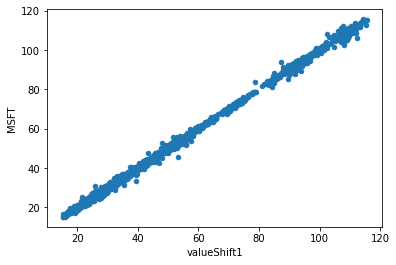

In [25]:
df_train.plot(kind= "scatter", y = "MSFT", x = "valueShift1");

In [26]:
#Not so much variance. Maybe cuadratic will work

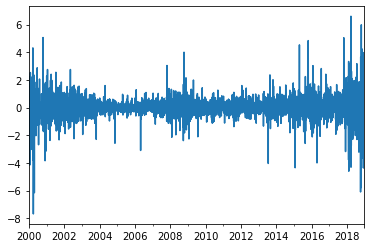

In [27]:
df_train["valueDiff"] = df_train.MSFT - df_train.valueShift1
df_train.valueDiff.plot();   #difference between target and lag period

In [28]:
#mean = 0  random walk is lag period

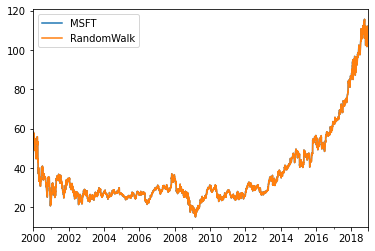

In [29]:
df_train["RandomWalk"] = df_train.valueShift1
df_train.plot(kind="line", y = ["MSFT", "RandomWalk"]);

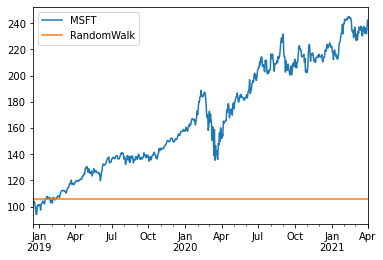

In [30]:
df_test["RandomWalk"] = pd.Series(df_train["MSFT"][-1], index=df_test.index)
df_test.plot(kind="line", y = ["MSFT", "RandomWalk"]);

In [31]:
Results.loc[1, "Model"] = "Random Walk"
Results.loc[1, "RMSE"] = RMSE(df_test.RandomWalk, df_test.MSFT)

#### Cuadratic Tendency

In [32]:
model_quadratic = smf.ols('MSFT ~ timeIndex + timeIndex_cuadratic', data = df_train).fit()
model_quadratic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MSFT   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 1.524e+04
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:28:17   Log-Likelihood:                -16808.
No. Observations:                4945   AIC:                         3.362e+04
Df Residuals:                    4942   BIC:                         3.364e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              44.7964      0.309    144.977      0.000      44.191      45.402
timeIndex              -0.0264      0.000    -91.413      0.000      -0.027      -0.026
timeIndex_cuadratic  7.107e-06   5.65e-08    125.708      0.000       7e-06    7.22e-06
==============================================================================
Omnibus:                      642.710   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1010.270
Skew:                           0.913   Prob(JB):                    4.19e-220
Kurtosis:                       4.252   Cond. No.                     3.28e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.28e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
df_train["QuadraticTrend"] = model_quadratic.predict(df_train[["timeIndex",\
                                                      "timeIndex_cuadratic"]])

df_test["QuadraticTrend"] = model_quadratic.predict(df_test[["timeIndex",\
                                                      "timeIndex_cuadratic"]])

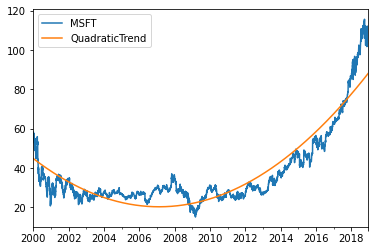

In [34]:
df_train.plot(kind = "line", y = ["MSFT","QuadraticTrend"]);

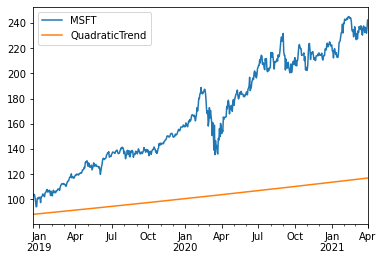

In [35]:
df_test.plot(kind = "line", y = ["MSFT", "QuadraticTrend"]);

In [36]:
Results.loc[2, "Model"] = "QuadraticTrend"
Results.loc[2, "RMSE"] = RMSE(df_test.QuadraticTrend, df_test.MSFT)

#### Exponential Tendency

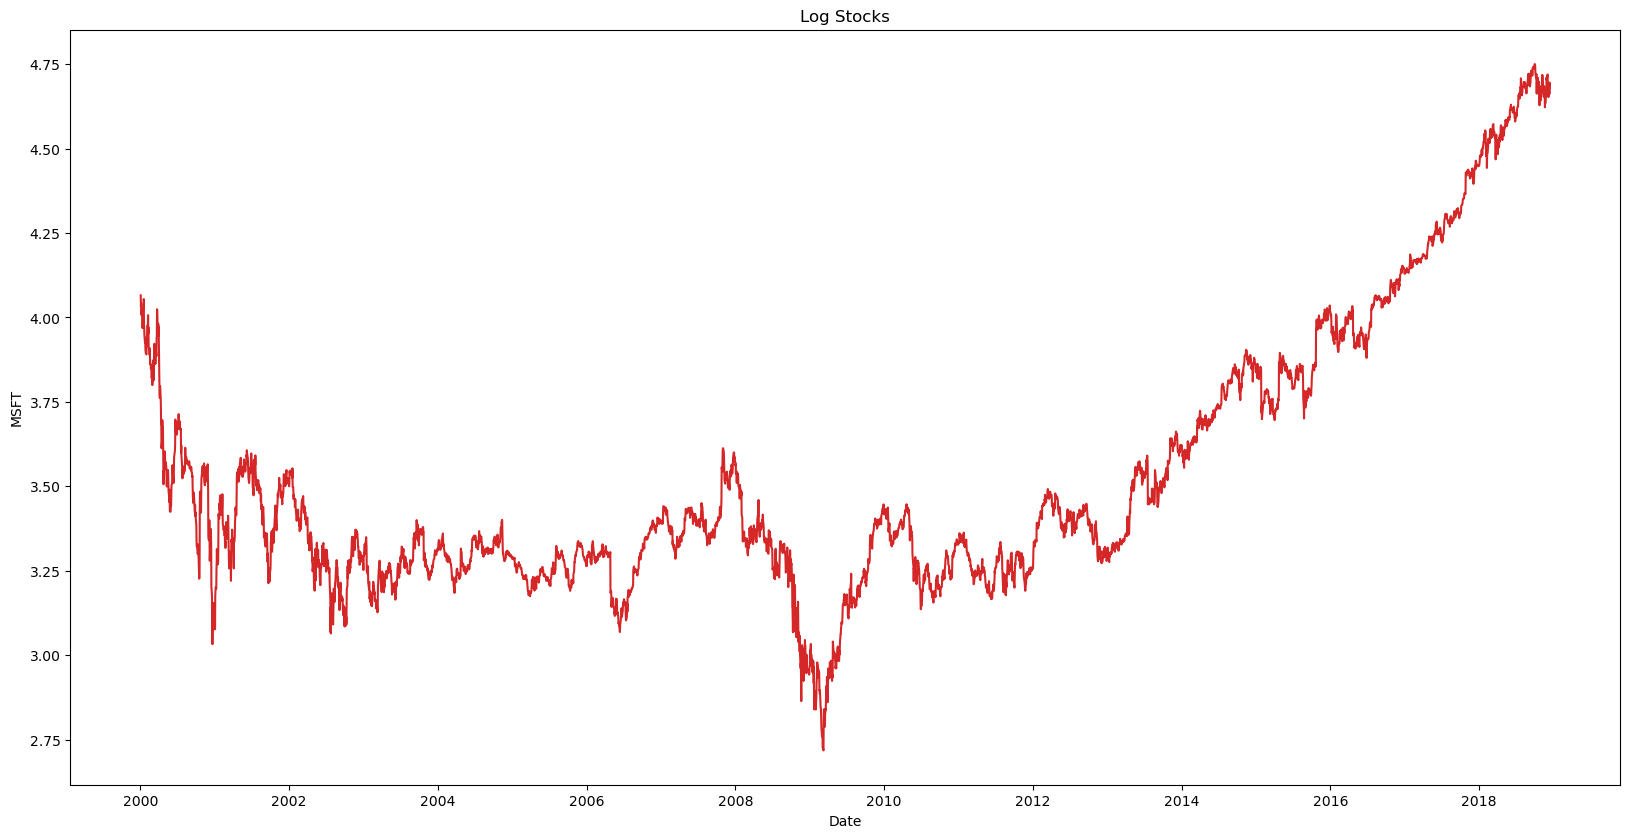

In [37]:
plot_df(df_train, x=df_train.index, y=df_train['timeIndex_log'],\
    title='Log Stocks')

In [38]:
model_log = smf.ols('timeIndex_log ~ timeIndex ', data = df_train).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          timeIndex_log   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     3685.
Date:                Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                        12:28:39   Log-Likelihood:                -1075.8
No. Observations:                4945   AIC:                             2156.
Df Residuals:                    4943   BIC:                             2169.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0809      0.009    360.131      0.000       3.064       3.098
timeIndex      0.0002      3e-06     60.706      0.000       0.000       0.000
==============================================================================
Omnibus:                      281.176   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.897
Skew:                           0.614   Prob(JB):                     2.31e-72
Kurtosis:                       3.305   Cond. No.                     5.71e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
df_train['model_log'] = model_log.predict(df_train[["timeIndex"]])
df_test['model_log'] = model_log.predict(df_test[["timeIndex"]])

In [40]:
df_train['back_model_log'] = np.exp(df_train['model_log'])
df_test['back_model_log'] = np.exp(df_test['model_log'])

In [41]:
df_test.head()

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,...,May,Nov,Oct,Sep,Mean,valueShift1,RandomWalk,QuadraticTrend,model_log,back_model_log
2018-12-17,102.889999,2018,Dec,4945,24453025,4.633660,0,1,0,0,...,0,0,0,0,37.473916,102.889999,106.029999,88.086597,3.980526,53.545198
2018-12-18,103.970001,2018,Dec,4946,24462916,4.644102,0,1,0,0,...,0,0,0,0,37.473916,102.889999,106.029999,88.130500,3.980708,53.554940
2018-12-19,103.690002,2018,Dec,4947,24472809,4.641406,0,1,0,0,...,0,0,0,0,37.473916,103.970001,106.029999,88.174418,3.980890,53.564685
2018-12-20,101.510002,2018,Dec,4948,24482704,4.620157,0,1,0,0,...,0,0,0,0,37.473916,103.690002,106.029999,88.218351,3.981072,53.574431
2018-12-21,98.230003,2018,Dec,4949,24492601,4.587312,0,1,0,0,...,0,0,0,0,37.473916,101.510002,106.029999,88.262297,3.981254,53.584178


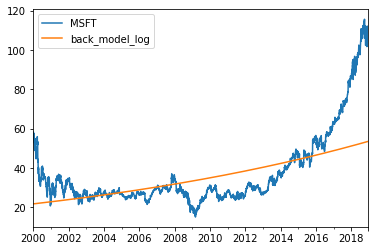

In [42]:
df_train.plot(kind = "line", y = ['MSFT', 'back_model_log']);

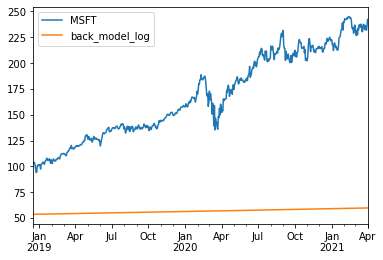

In [43]:
df_test.plot(kind = "line", y = ['MSFT', 'back_model_log']);

In [44]:
Results.loc[3, "Model"] = "Transf Log"
Results.loc[3, "RMSE"] = RMSE(df_test['back_model_log'], df_test['MSFT'])

#### Combine Cuadratic Tendency With Month Dummies

In [45]:
model_log_est = smf.ols('timeIndex_cuadratic ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = df_train).fit()
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     timeIndex_cuadratic   R-squared:                       0.938
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                     6166.
Date:                 Sat, 03 Apr 2021   Prob (F-statistic):               0.00
Time:                         12:29:16   Log-Likelihood:                -78302.
No. Observations:                 4945   AIC:                         1.566e+05
Df Residuals:                     4932   BIC:                         1.567e+05
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.092e+06   1.01e+05    -40.585      0.000   -4.29e+06   -3.89e+06
timeIndex   4944.3460     18.197    271.708      0.000    4908.671    4980.021
Aug         4.468e+04   1.27e+05      0.352      0.725   -2.04e+05    2.93e+05
Dec         -1.04e+05   1.28e+05     -0.812      0.417   -3.55e+05    1.47e+05
Feb         3.403e+04    1.3e+05      0.262      0.793   -2.21e+05    2.89e+05
Jan           4.1e+04   1.27e+05      0.323      0.747   -2.08e+05     2.9e+05
Jul         7554.1390   1.27e+05      0.059      0.953   -2.42e+05    2.57e+05
Jun         1.848e+04   1.28e+05      0.144      0.885   -2.33e+05     2.7e+05
Mar         3.203e+04   1.27e+05      0.252      0.801   -2.17e+05    2.81e+05
May         4.945e+04   1.27e+05      0.390      0.697   -1.99e+05    2.98e+05
Nov         4.514e+04   1.28e+05      0.353      0.724   -2.06e+05    2.96e+05
Oct         3.941e+04   1.27e+05      0.310      0.756   -2.09e+05    2.88e+05
Sep         1331.2617   1.28e+05      0.010      0.992    -2.5e+05    2.53e+05
==============================================================================
Omnibus:                      836.321   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              486.729
Skew:                           0.637   Prob(JB):                    2.03e-106
Kurtosis:                       2.141   Cond. No.                     3.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

P-values = Months dont matter at all. Stationality not working aparently

In [47]:
df_train['model_quad_est'] = model_log_est.predict(df_train[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_quad_est'] = model_log_est.predict(df_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [48]:
df_train

,MSFT,year,month,timeIndex,timeIndex_cuadratic,timeIndex_log,Aug,Dec,Feb,Jan,...,Oct,Sep,Mean,valueShift1,valueDiff,RandomWalk,QuadraticTrend,model_log,back_model_log,model_quad_est
2000-01-03,58.281250,2000,Jan,0,0,4.065280,0,0,0,1,...,0,0,37.473916,58.281250,0.000000,58.281250,44.796420,3.080877,21.777500,-4.050598e+06
2000-01-04,56.312500,2000,Jan,1,1,4.030917,0,0,0,1,...,0,0,37.473916,58.281250,-1.968750,58.281250,44.770039,3.081059,21.781463,-4.045654e+06
2000-01-05,56.906250,2000,Jan,2,4,4.041405,0,0,0,1,...,0,0,37.473916,56.312500,0.593750,56.312500,44.743672,3.081241,21.785426,-4.040709e+06
2000-01-06,55.000000,2000,Jan,3,9,4.007333,0,0,0,1,...,0,0,37.473916,56.906250,-1.906250,56.906250,44.717319,3.081423,21.789390,-4.035765e+06
2000-01-07,55.718750,2000,Jan,4,16,4.020317,0,0,0,1,...,0,0,37.473916,55.000000,0.718750,55.000000,44.690981,3.081605,21.793354,-4.030821e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-10,107.589996,2018,Dec,4940,24403600,4.678328,0,1,0,0,...,0,0,37.473916,104.820000,2.769997,104.820000,87.867290,3.979616,53.496512,2.022951e+07
2018-12-11,108.589996,2018,Dec,4941,24413481,4.687579,0,1,0,0,...,0,0,37.473916,107.589996,1.000000,107.589996,87.911123,3.979798,53.506246,2.023445e+07
2018-12-12,109.080002,2018,Dec,4942,24423364,4.692082,0,1,0,0,...,0,0,37.473916,108.589996,0.490005,108.589996,87.954970,3.979980,53.515981,2.023940e+07
2018-12-13,109.449997,2018,Dec,4943,24433249,4.695468,0,1,0,0,...,0,0,37.473916,109.080002,0.369995,109.080002,87.998831,3.980162,53.525718,2.024434e+07


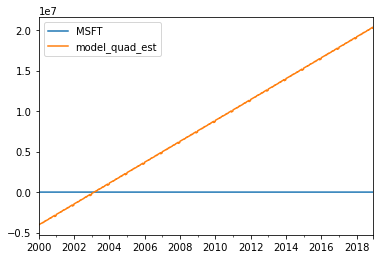

In [51]:
df_train.plot(kind = "line", y = ['MSFT', 'model_quad_est']);

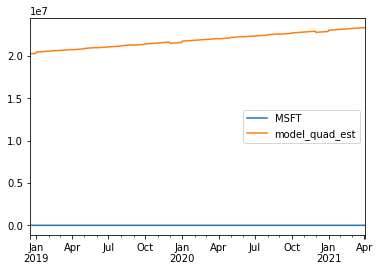

In [52]:
df_test.plot(kind = "line", y = ['MSFT', 'model_quad_est']);

In [53]:
Results.loc[4, "Model"] = "Quad + Est"
Results.loc[4, "RMSE"] = RMSE(df_test['model_quad_est'], df_test['MSFT'])
Results

,Model,RMSE
0,Mean,137.404076
1,Random Walk,75.112646
2,QuadraticTrend,74.380685
3,Transf Log,118.76121
4,Quad + Est,21872358.247056


#### SimpleExpSmoothing

In [54]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


In [55]:
from sklearn.model_selection import TimeSeriesSplit 

tscv = TimeSeriesSplit(n_splits=5)

In [56]:
from sklearn.metrics import mean_squared_error

def timeseriesCVscore_exp_smoot(alpha, series):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        
    """
    # errors array :
    errors = []
    
    values = series.values
    
    # tscv:
    tscv = TimeSeriesSplit(n_splits=5) 
    
    # cross validation:

    for train, test in tscv.split(values):
    
        model = SimpleExpSmoothing(values[train]).fit(smoothing_level=alpha,\
                                                             optimized=False)
        
        predictions = model.forecast(len(test))
        actual = values[test]
    
        error = mean_squared_error(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [57]:
alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.7]
errors = []

for alpha in alphas:
    error = timeseriesCVscore_exp_smoot(alpha, df_train.MSFT)
    errors.append(error)

print('Best Alpha:', alphas[np.argmin(errors)])

Best Alpha: 0.7


In [58]:
model_exp_smoothing = SimpleExpSmoothing(df_train.MSFT).fit(smoothing_level=alphas[np.argmin(errors)],\
                                                             optimized=False)                                                        

In [59]:
df_test["smoothing"] = model_exp_smoothing.forecast(600)

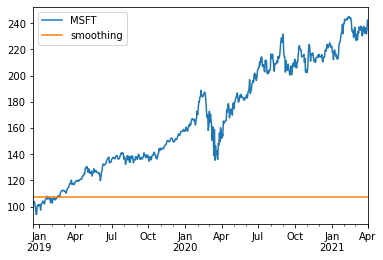

In [60]:
df_test.plot(kind="line", y = ["MSFT",'smoothing']);

In [61]:
Results.loc[5, "Model"] = "Simple Smoothing"
Results.loc[5, "RMSE"] = RMSE(df_test["smoothing"], df_test.MSFT)

#### Dickey-Fuller
See if i can use arima

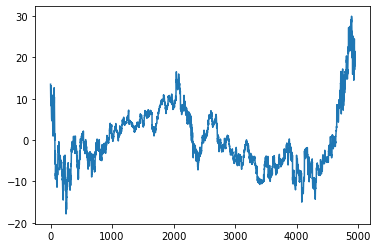

In [62]:
res_model = df_train['MSFT'] - df_train['QuadraticTrend']

plt.plot(df_train.timeIndex, res_model, '-');

In [63]:
# Dickey-Fuller to residual
from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Critic Value %s: %.2f' % (key,value))

ADF Statistic: -2.382437
p-value: 0.146755
Critic Value 1%: -3.43
Critic Value 5%: -2.86
Critic Value 10%: -2.57


In [64]:
#p-value high. cant use arima.

https://facebook.github.io/prophet/docs/diagnostics.html

#### Prophet

In [65]:
from fbprophet import Prophet

In [66]:
data = pd.read_csv('Data_Microsoft.csv')

In [67]:
data['Unnamed: 0'] =  pd.to_datetime(data['Unnamed: 0'])

In [68]:
data.rename(columns = {'Unnamed: 0':'ds','MSFT':'y'},inplace = True)

In [69]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size=12, shuffle=False)

In [70]:
m = Prophet(daily_seasonality=True)
m.fit(df_train)

In [71]:
#use model to predict
forecast = m.predict(df_test)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-03-18,220.938730,203.060928,219.974422,220.938730,220.938730,-9.351624,-9.351624,-9.351624,-7.235676,...,-0.339169,-0.339169,-0.339169,-1.776779,-1.776779,-1.776779,0.0,0.0,0.0,211.587106
1,2021-03-19,221.046555,203.020540,220.342167,221.046555,221.046555,-9.408862,-9.408862,-9.408862,-7.235676,...,-0.349173,-0.349173,-0.349173,-1.824013,-1.824013,-1.824013,0.0,0.0,0.0,211.637692
2,2021-03-22,221.370029,203.080260,220.204591,221.370029,221.370029,-9.564759,-9.564759,-9.564759,-7.235676,...,-0.396058,-0.396058,-0.396058,-1.933025,-1.933025,-1.933025,0.0,0.0,0.0,211.805270
3,2021-03-23,221.477854,203.374785,220.117791,221.477854,221.477854,-9.573576,-9.573576,-9.573576,-7.235676,...,-0.379001,-0.379001,-0.379001,-1.958900,-1.958900,-1.958900,0.0,0.0,0.0,211.904278
4,2021-03-24,221.585679,203.566507,220.196538,221.585679,221.585679,-9.560985,-9.560985,-9.560985,-7.235676,...,-0.345517,-0.345517,-0.345517,-1.979792,-1.979792,-1.979792,0.0,0.0,0.0,212.024693


In [72]:
df_test = df_test.set_index(df_test.ds)

In [73]:
df_test.drop(columns = ['ds'],inplace = True)

In [74]:
forecast = forecast.set_index(forecast.ds)

In [75]:
forecast = forecast.yhat

In [76]:
df_test["prophet"] = forecast

In [77]:
df_test

,y,prophet
ds,,
2021-03-18,230.720001,211.587106
2021-03-19,230.350006,211.637692
2021-03-22,235.990005,211.805270
2021-03-23,237.580002,211.904278
2021-03-24,235.460007,212.024693
2021-03-25,232.339996,212.122802
2021-03-26,236.479996,212.209237
2021-03-29,235.240005,212.478446
2021-03-30,231.850006,212.609446


In [78]:
Results.loc[6, "Model"] = "Prophet"
Results.loc[6, "RMSE"] = RMSE(df_test["prophet"], df_test.y)

In [79]:
#make future predictions with prophet function
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
5893,2022-03-13
5894,2022-03-14
5895,2022-03-15
5896,2022-03-16
5897,2022-03-17


In [80]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5893,2022-03-13,251.987953,241.851868,261.646206
5894,2022-03-14,250.718572,240.544763,260.024355
5895,2022-03-15,250.772270,240.530556,260.420658
5896,2022-03-16,250.848001,241.274374,261.187959
5897,2022-03-17,250.902256,241.213455,260.748592


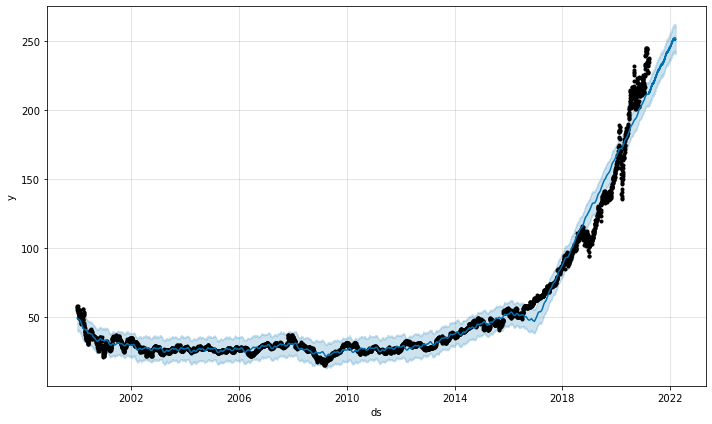

In [81]:
fig1 = m.plot(forecast)

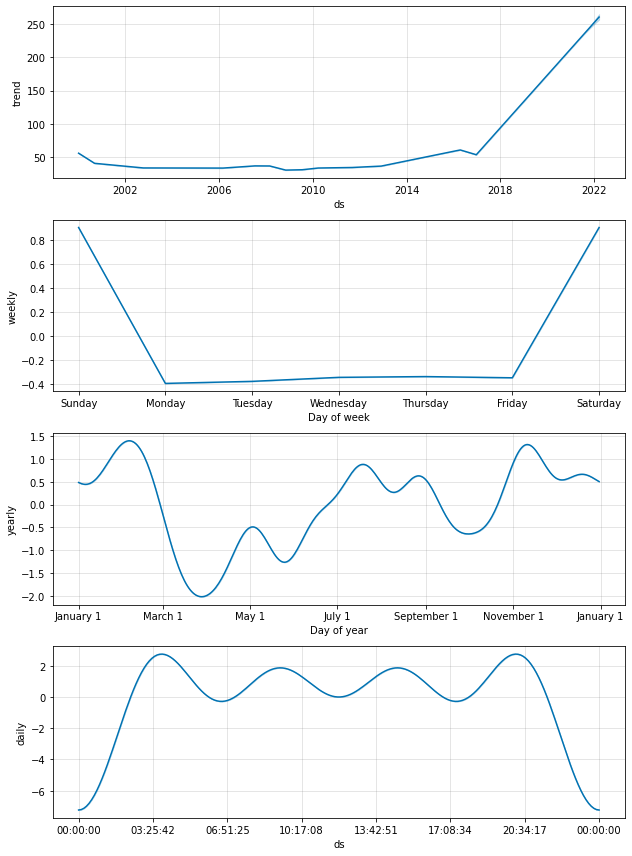

In [82]:
fig2 = m.plot_components(forecast)

#### RNN with LSTM

Used time frame of 60 days for neurons to learn and look up.

In [83]:
data = pd.read_csv('Data_Microsoft.csv')

In [84]:
data.rename(columns = {'Unnamed: 0':'ds','MSFT':'y'},inplace = True)

In [85]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size=12, shuffle=False)

In [86]:
training_set =df_train.iloc[:, 1:2].values

In [87]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [88]:
#thre previous days. 60 = previous 3 months to look at
X_train = []  #input. contains previous 60 days from that day
y_train = []  #output. contains value for next financial day 
for i in range(60, 5519): #60 because you can only start at 60 if you getting the past 60 days. 5519 because number of observations in training set. training_set.shape 
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [89]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 


In [90]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [91]:
regressor = Sequential()

In [92]:
regressor.add(LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], 1)))     
regressor.add(Dropout(0.2))  

In [93]:
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))

In [94]:
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))

In [95]:
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))

In [96]:
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))

In [97]:
regressor.add(LSTM(units = 80))
regressor.add(Dropout(0.2))

In [98]:
regressor.add(Dense(units = 1))

In [99]:
#ok so 80 neurons in each layer. 6 LSTM layers + output

In [100]:
regressor.compile(optimizer = 'RMSprop', loss = 'mse') #RMSdrop as opt is the default to use 

In [101]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
171/171 [==============================] - 27s 111ms/step - loss: 0.01650s - loss:
Epoch 2/100
171/171 [==============================] - 20s 116ms/step - loss: 0.0030
Epoch 3/100
171/171 [==============================] - 19s 109ms/step - loss: 0.0021
Epoch 4/100
171/171 [==============================] - 18s 108ms/step - loss: 0.0021
Epoch 5/100
171/171 [==============================] - 18s 107ms/step - loss: 0.0016
Epoch 6/100
171/171 [==============================] - 19s 111ms/step - loss: 0.0015
Epoch 7/100
171/171 [==============================] - 19s 110ms/step - loss: 0.0014
Epoch 8/100
171/171 [==============================] - 19s 113ms/step - loss: 9.9156e-04
Epoch 9/100
171/171 [==============================] - 20s 115ms/step - loss: 0.0012
Epoch 10/100
171/171 [==============================] - 19s 110ms/step - loss: 0.0010
Epoch 11/100
171/171 [==============================] - 19s 113ms/step - loss: 8.8710e-04
Epoch 12/100
171/171 [=======================

In [102]:
dataset_total = pd.concat((df_train['y'], df_test['y']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60,72):  # 60 + 12
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [103]:
df_test_index = df_test.reset_index()

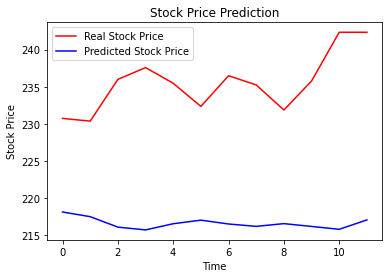

In [104]:
plt.plot(df_test_index['y'], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [105]:
df_test_index["rnn"] = predicted_stock_price

In [106]:
Results.loc[7, "Model"] = "RNN"
Results.loc[7, "RMSE"] = RMSE(df_test_index["rnn"], df_test_index['y'])

-----

In [107]:
Results

,Model,RMSE
0,Mean,137.404076
1,Random Walk,75.112646
2,QuadraticTrend,74.380685
3,Transf Log,118.76121
4,Quad + Est,21872358.247056
5,Simple Smoothing,74.312334
6,Prophet,23.547953
7,RNN,19.438503


RNN gives better results, but Prophet is somewhat easier to implement so i'll used that one to deploy.

In [108]:
import pickle
with open('model_prophet.pkl', 'wb') as f_model_prophet:
    pickle.dump(m,f_model_prophet)